In [347]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import matplotlib.pyplot as plt
#import cPickle as pickle
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [348]:
childhood = 200
training1 = childhood+90
glasses_on = training1+136
training2 = glasses_on+90
mod = 23*(np.pi/180) #degrees

In [349]:
def training_fn(t):
    if (t<= childhood) or (training1 <= t < glasses_on):
        return 1
    else:
        return 0

def glasses_fn(t):
    if t >= training1:
        return 1
    else:
        return 0

time_per_val = 0.5
time_per_val_testing = 1.0
dist = nengo.dists.Uniform(-np.pi, np.pi) 
vals_testing = np.linspace(0,2*np.pi,90)
training_time1 = childhood
training_time2 = glasses_on-training1
vals_training1 = dist.sample((training_time1/time_per_val)+1)
vals_training2 = dist.sample((training_time2/time_per_val)+1)
    

def stim_fn(t, x):
    glasses, train = x
    if glasses == 0 and train ==1:
        # First training period, random things appear
        index = int((t - 0)/time_per_val)
        return vals_training1[index]
    if glasses == 0 and train == 0: 
        # Test the owl by forcing it to incrimentally look at all the things
        # Gives data to form pre-learning tuning curve
        index = int((t - childhood)/time_per_val_testing)
        return vals_testing[index]
    if glasses ==1 and train == 1:
        # Second Training period, random things appear
        index = int((t - training1)/time_per_val)
        return vals_training2[index]
    if glasses == 1 and train == 0:
        # Last period, test owl by forcing it to incrimentally look at things
        index = int((t-glasses_on)/time_per_val_testing)
        return vals_testing[index % len(vals_testing)]
        
def convert_to_circle(x):
    #takes a value in RADIANS, converts ton x y cartesian coordinates
    # x is gonna be an angle value, we're assuming r=1 for the sake of simplicity
    return np.cos(x), np.sin(x)
    
def is_mod_fn(t, x):
    stim, glasses = x
    if glasses == 1:
        return stim+mod
    else:
        return stim

def error_on(training):
    if training == 1:
        return 1
    else:    
        return 0
        
model = nengo.Network()
with model:
    training = nengo.Node(training_fn)
    glasses = nengo.Node(glasses_fn)
    stim = nengo.Node(stim_fn, size_in = 2, size_out = 1)
    use_mod = nengo.Node(is_mod_fn, size_in = 2, size_out = 1) 
    
    train2stim = nengo.Connection(training, stim[1], synapse = None)
    glasses2stim = nengo.Connection(glasses, stim[0], synapse = None)
    
    # Connecting a bunch of different ensembles
    visual_raw = nengo.Ensemble(n_neurons=300, dimensions=3, intercepts = nengo.dists.Uniform(0.81,0.91))
    auditory = nengo.Ensemble(n_neurons=200, dimensions = 2, intercepts = nengo.dists.Uniform(0.81,0.91))
    stim2use_mod = nengo.Connection(stim, use_mod[0], synapse = None)
    glasses2use_mod = nengo.Connection(glasses, use_mod[1], synapse = None)
    use_mod2vis = nengo.Connection(use_mod, visual_raw[:2], function = convert_to_circle)
    stim2aud = nengo.Connection(stim, auditory, function = convert_to_circle)
    
    # Error stuff
    error = nengo.Ensemble(n_neurons = 400, dimensions = 2) #error_fn, size_in = 4, size_out = 2)
    visual_cor = nengo.Ensemble(n_neurons = 200, dimensions = 2)
    vis2vis = nengo.Connection(visual_raw[:2], visual_cor[:2],synapse = 0.1, learning_rule_type = nengo.PES())
    vis2vis.solver = nengo.solvers.LstsqL2(weights = True)
    aud2error = nengo.Connection(auditory[:2], error[:2], transform = -1)
    vis2error = nengo.Connection(visual_cor[:2], error[:2])
    
    nengo.Connection(error, vis2vis.learning_rule)
    
    probe = nengo.Probe(visual_cor.neurons)

In [ ]:
sim = nengo.Simulator(model)
sim.run(training2)

In [331]:
print(sim.trange()[-1])
print(training2)
x = vals_testing

#print((180/np.pi)*(x[i]-x[i+1]))
y = sim.data[probe]#[-int():]
#pickle.dump(sim.data[probe], open(owldata, 'wb'))
print(y.shape)
print(len(y))
z = sim.trange()
print (len(z))
print(z.shape)

230.0
230
(230000, 200)
230000
230000
(230000,)


In [ ]:
 def calc_norm(rates, rate_peaks=None):
        #assume that cells with similar peak centers would fall under the same
        #multicellular recording therefore peaks are done relative to all values with similar peaks
        nrm_rates = []
        if rate_peaks is None:
            rate_peaks = np.max(rates, axis=0)
            rate_peaks = np.array([p if p > 0 else 1 for p in rate_peaks])
        max_i = np.argmax(rates, axis=0)
        for j, i in enumerate(max_i):
            nrm_rates.append(rates[:, j]/rate_peaks[i])
        nrm_rates = np.array(nrm_rates).transpose()
        return nrm_rates, rate_peaks
    
    #x = calc_norm (mean1_activity)
    print (x)

321.0 325.0
90 45 45
(90, 1)


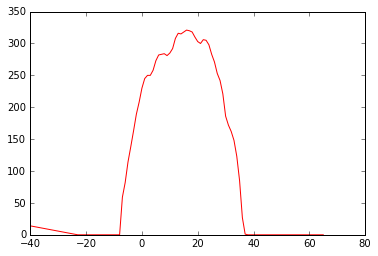

In [333]:
for i in range(2,3):

    activity = y[:,i]
    dt = 0.001

    test1_activity = activity[int(childhood/dt):int(training1/dt)]
    test2_activity = activity[int(glasses_on/dt):int(training2/dt)]

    mean1_activity = np.mean(test1_activity.reshape(90, 1000),axis=1)
    mean2_activity = np.mean(test2_activity.reshape(90, 1000),axis=1)

    max_mean1 = mean1_activity.max()
    max_mean2 = mean2_activity.max()
    print(max_mean1, max_mean2)
    indices1 = np.where(mean1_activity==mean1_activity.max())
    indices2 = np.where(mean2_activity==mean2_activity.max())
    increment = int(indices1[0][0])
    increment2 = int(indices2[0][0])
    #print(increment, increment2)
    
    for j in range(len(mean1_activity)-1):
        rightmost = np.asarray(np.where(mean1_activity>0))
        r = rightmost[-1][-1]
        
    a = np.where(mean1_activity >= 0)
    a = np.asarray(a)
 
    indicies_to_adjust1 = np.where(mean1_activity[0:r])
    indicies_to_adjust1 = np.asarray(indicies_to_adjust1)
    indicies_to_adjust1[:] = [(x-increment) for x in indicies_to_adjust1]

    x = (indicies_to_adjust1[-1][-1]) + 1
    tobeadded = a.shape[1]- indicies_to_adjust1.shape[1]
    print(a.shape[1], indicies_to_adjust1.shape[1], tobeadded)
    extra_numbers = []
    i = 0
    for i in range(tobeadded):
        extra_numbers.append(x)
        x += 1
        
    extra_numbers = np.asarray(extra_numbers)
    indicies_simplified1 = indicies_to_adjust1[0]
    k = np.hstack((indicies_simplified1,extra_numbers))
    #adj_val1 = indicies_to_adjust1.shape[1]
    
    
    
    
    
    
    indicies_to_adjust2 = np.where(mean2_activity >= 0)
    indicies_to_adjust2 = np.asarray(indicies_to_adjust2)
    indicies_to_adjust2[:] = [(x-increment2) for x in indicies_to_adjust2]
    #print(indicies_to_adjust2)

    #indicies_to_adjust1 = indicies_to_adjust1.reshape(90, 1)
    k = k.reshape(k.shape[0],1)
    k = np.asarray(k)
    print(k.shape)
    #k[:] = [(x-increment)for x in k]
    indicies_to_adjust2 = indicies_to_adjust2.reshape(90,1)
    pylab.plot(k, mean1_activity, c='r')
    #pylab.plot(indicies_to_adjust2, mean2_activity, c='b')
    #plt.xlabel('ITD relative to best')
    

418.0 416.0


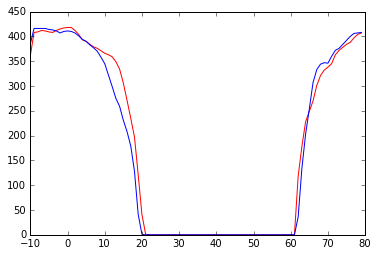

In [346]:
for i in [12]:

    activity = y[:,i]
    dt = 0.001

    test1_activity = activity[int(childhood/dt):int(training1/dt)]
    test2_activity = activity[int(glasses_on/dt):int(training2/dt)]

    mean1_activity = np.mean(test1_activity.reshape(90, 1000),axis=1)
    mean2_activity = np.mean(test2_activity.reshape(90, 1000),axis=1)

    max_mean1 = mean1_activity.max()
    max_mean2 = mean2_activity.max()
    print(max_mean1, max_mean2)
    indices1 = np.where(mean1_activity==mean1_activity.max())
    indices2 = np.where(mean2_activity==mean2_activity.max())
    increment = int(indices1[0][0])
    increment2 = int(indices2[0][0])
    #print(increment, increment2)
    
    pylab.plot(np.arange(len(mean1_activity)) - increment, mean1_activity, c='r')
    pylab.plot(np.arange(len(mean2_activity)) - increment, mean2_activity, c='b')
    '''
    a = np.where(mean1_activity >= 0)
    a = np.asarray(a)
 
    indicies_to_adjust1 = np.where(mean1_activity >=0)
    indicies_to_adjust1 = np.asarray(indicies_to_adjust1)
    indicies_to_adjust1[:] = [(x-increment) for x in indicies_to_adjust1]

    
    
    indicies_to_adjust2 = np.where(mean2_activity >= 0)
    indicies_to_adjust2 = np.asarray(indicies_to_adjust2)
    indicies_to_adjust2[:] = [(x-increment2) for x in indicies_to_adjust2]
    #print(indicies_to_adjust2)

    pylab.plot(indicies_to_adjust1, mean1_activity, c='r')
    pylab.plot(indicies_to_adjust2, mean2_activity, c='b')
    #plt.xlabel('ITD relative to best')
    '''
    